Meal columns detected: 9
 - Please rate how often you eat at each of the following on-campus meal options on a scale of 1 to 5 (1 being Never, 5 being Very Often). [Subway]
 - Please rate how often you eat at each of the following on-campus meal options on a scale of 1 to 5 (1 being Never, 5 being Very Often). [Habit Burger]
 - Please rate how often you eat at each of the following on-campus meal options on a scale of 1 to 5 (1 being Never, 5 being Very Often). [Panda Express]
 - Please rate how often you eat at each of the following on-campus meal options on a scale of 1 to 5 (1 being Never, 5 being Very Often). [Chronic Tacos]
 - Please rate how often you eat at each of the following on-campus meal options on a scale of 1 to 5 (1 being Never, 5 being Very Often). [Hibachi-san]
 - Please rate how often you eat at each of the following on-campus meal options on a scale of 1 to 5 (1 being Never, 5 being Very Often). [Halal Shack]
 - Please rate how often you eat at each of the following

C:\Users\Jonat\AppData\Local\Temp\ipykernel_9004\1821785308.py:47: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  meal_data = df[meal_cols].applymap(clean_rating)


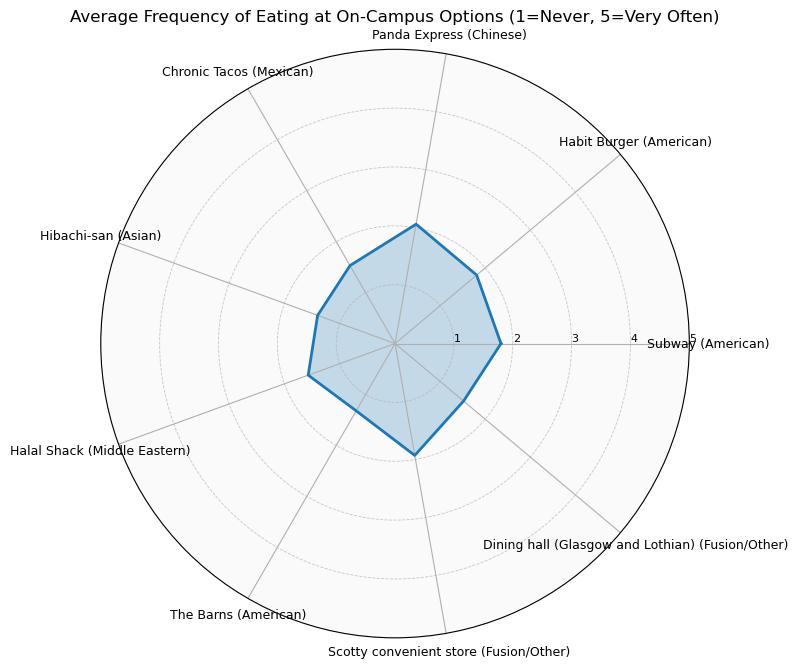

In [43]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# ---- Load the dataset ----
df = pd.read_csv("responses.csv")

# ---- Define restaurant-cuisine mapping ----
# You can replace this with actual restaurant names and cuisine types
restaurant_cuisines = {
    "The Barns": "American",
    "Subway": "American",
    "Panda Express": "Chinese",
    "Habit Burger": "American",
    "Hibachi-san": "Asian",
    "Chronic Tacos": "Mexican",
    "Dining hall (Glasgow and Lothian)" : "Fusion/Other",
    "Scotty convenient store" : "Fusion/Other",
    "Halal Shack" : "Middle Eastern"
    # Add more restaurants and their cuisines here
}

# ---- Select columns: on-campus meal frequency ----
meal_cols = [
    col for col in df.columns
    if "Please rate how often you eat at each of the following on-campus meal options" in col
]

print(f"Meal columns detected: {len(meal_cols)}")
for c in meal_cols:
    print(" -", c)

# ---- Clean ratings to integers 1–5 ----
def clean_rating(x):
    """
    Converts Google Form mixed strings like '5', '5.0', '5 - Very Often'
    to int 1–5; returns NaN if not parseable.
    """
    if pd.isna(x):
        return np.nan
    x = str(x).strip()
    for ch in x:
        if ch.isdigit():
            return int(ch)
    return np.nan

meal_data = df[meal_cols].applymap(clean_rating)

# ---- Compute averages (per restaurant) ----
avg_ratings = meal_data.mean().round(2)

# ---- Pretty labels (inside square brackets) with cuisine types ----
labels = [f"{col.split('[')[-1].split(']')[0]} ({restaurant_cuisines.get(col.split('[')[-1].split(']')[0], 'Unknown')})" for col in meal_cols]

# ---- Radar prep ----
values = avg_ratings.values.tolist()
values += values[:1]  # close loop

angles = np.linspace(0, 2 * np.pi, len(labels), endpoint=False).tolist()
angles += angles[:1]

# ---- Plot (Radar) ----
plt.figure(figsize=(8, 8))
ax = plt.subplot(111, polar=True)

ax.plot(angles, values, linewidth=2, linestyle="solid", color="#1f77b4")
ax.fill(angles, values, alpha=0.25, color="#1f77b4")

# ---- Axis labels ----
ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels, fontsize=9)

# ---- Set explicit floor/ceiling and tick marks ----
ax.set_ylim(0, 3)
ax.set_yticks([1, 2, 3, 4, 5])
ax.set_yticklabels(["1", "2", "3", "4", "5"], fontsize=8)
ax.yaxis.grid(True, linestyle="--", linewidth=0.6, alpha=0.7)

# ---- Optional: emphasize visual spacing for ratings ----
ax.set_rlabel_position(0)
ax.set_facecolor("#fafafa")

plt.title("Average Frequency of Eating at On-Campus Options (1=Never, 5=Very Often)", pad=20)
plt.tight_layout()
plt.show()


C:\Users\Jonat\AppData\Local\Temp\ipykernel_9004\3997574169.py:42: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df[cuisine_cols] = df[cuisine_cols].applymap(clean_rating)


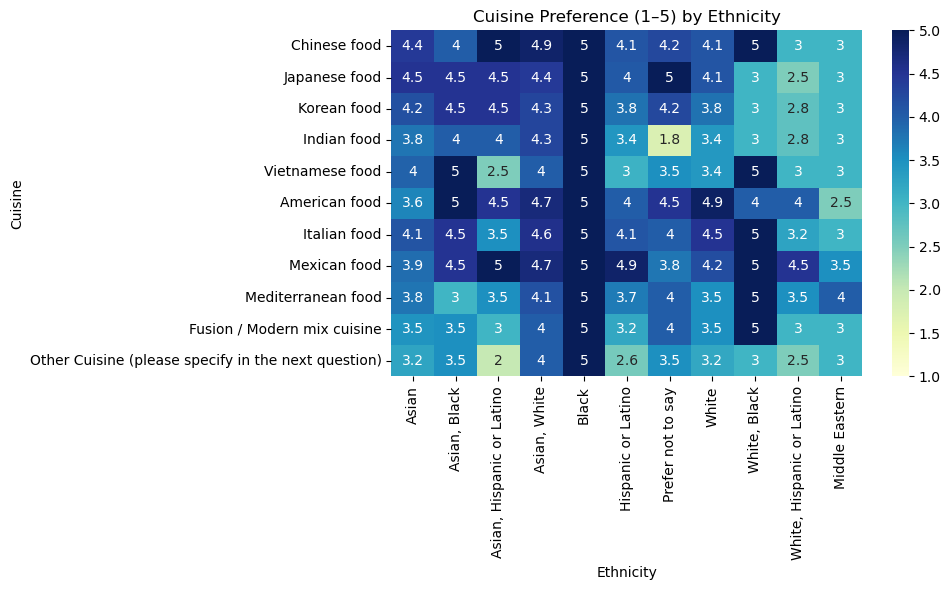


Number of responses per ethnicity:
What is your ethnicity?
Asian                        70
Hispanic or Latino           21
White                        10
Asian, White                  7
Prefer not to say             4
White, Hispanic or Latino     4
Asian, Hispanic or Latino     2
Asian, Black                  2
White, Black                  1
Middle eastern                1
Middle Eastern                1
Black                         1
Name: count, dtype: int64


In [45]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import re

# ---- Load ----
df = pd.read_csv("responses.csv")

# ---- Normalize headers (handle newlines / smart quotes) ----
def _norm(c: str) -> str:
    c = str(c)
    c = c.replace("\r", " ").replace("\n", " ")
    c = c.replace(""", '"').replace(""", '"').replace("'", "'")
    c = re.sub(r"\s+", " ", c).strip()
    return c

df.columns = [_norm(c) for c in df.columns]

# ---- Detect columns ----
eth_cols = [c for c in df.columns if "ethnic" in c.lower()]
assert eth_cols, "Could not find an ethnicity column (searching for 'ethnic')."
eth_col = eth_cols[0]

cuisine_cols = [
    c for c in df.columns
    if "please rank the following cuisines by your preference" in c.lower()
]
assert cuisine_cols, "No cuisine preference columns found."

# ---- Clean Likert values to integers 1–5 ----
def clean_rating(x):
    if pd.isna(x): 
        return np.nan
    s = str(x).strip()
    # handles "5", "5.0", "5 - Like", "  4 (Neutral)  "
    for ch in s:
        if ch.isdigit():
            return int(ch)
    return np.nan

df[cuisine_cols] = df[cuisine_cols].applymap(clean_rating)

# ---- Average by ethnicity ----
mean_by_eth = df.groupby(eth_col, dropna=False)[cuisine_cols].mean()

# ---- Pretty cuisine labels (text inside [...]) ----
pretty_names = {c: c.split('[')[-1].split(']')[0] if '[' in c and ']' in c else c for c in mean_by_eth.columns}
mean_by_eth = mean_by_eth.rename(columns=pretty_names)

# ---- Filter out "Other" cuisine ----
mean_by_eth = mean_by_eth[[col for col in mean_by_eth.columns if col.lower() != 'other']]

# ---- Combine Middle Eastern variations ----
# First, get all Middle Eastern rows (case-insensitive)
middle_eastern_mask = mean_by_eth.index.str.lower().str.contains('middle.*eastern')
middle_eastern_rows = mean_by_eth[middle_eastern_mask]

if len(middle_eastern_rows) > 1:
    # Compute weighted average based on number of responses for each variant
    counts = df[eth_col].value_counts()
    weights = counts[middle_eastern_rows.index]
    combined_row = (middle_eastern_rows * weights.values[:, np.newaxis]).sum() / weights.sum()
    
    # Remove all Middle Eastern variants and add the combined row
    mean_by_eth = mean_by_eth[~middle_eastern_mask]
    mean_by_eth.loc['Middle Eastern'] = combined_row

# ---- Heatmap ----
plt.figure(figsize=(10, 6))
sns.heatmap(mean_by_eth.T, annot=True, cmap="YlGnBu", vmin=1, vmax=5)
plt.title("Cuisine Preference (1–5) by Ethnicity")
plt.xlabel("Ethnicity")
plt.ylabel("Cuisine")
plt.tight_layout()
plt.show()

# Print counts to help interpret the data
print("\nNumber of responses per ethnicity:")
print(df[eth_col].value_counts().head(15))  # Show top 10 most common responses

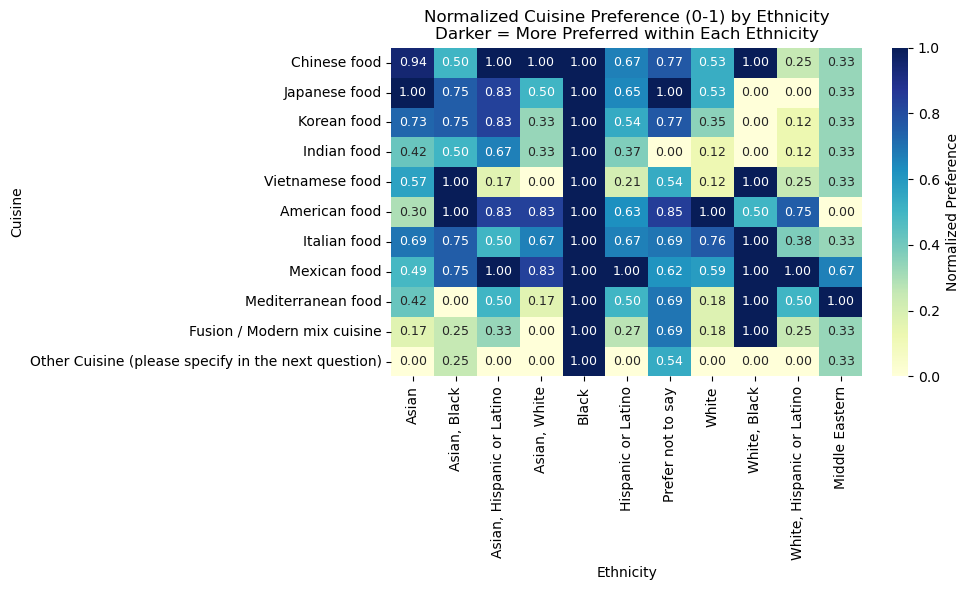


Ethnicity distribution:
What is your ethnicity?
Asian                        70
Hispanic or Latino           21
White                        10
Asian, White                  7
Prefer not to say             4
White, Hispanic or Latino     4
Asian, Hispanic or Latino     2
Asian, Black                  2
White, Black                  1
Middle eastern                1
Name: count, dtype: int64


In [46]:
# ---- Create normalized version (0-1 scale per ethnicity) ----
# Min-max normalization for each ethnicity (row)
norm_by_eth = mean_by_eth.copy()  # Using the filtered mean_by_eth (without "Other" cuisine and combined Middle Eastern)
for eth in norm_by_eth.index:
    row = norm_by_eth.loc[eth]
    if not row.isna().all():  # Only normalize if we have some non-NaN values
        row_min, row_max = row.min(), row.max()
        if row_min != row_max:  # Avoid division by zero if all values are the same
            norm_by_eth.loc[eth] = (row - row_min) / (row_max - row_min)
        else:
            norm_by_eth.loc[eth] = 1  # If all values are the same, normalize to 1

# ---- Heatmap of normalized values ----
plt.figure(figsize=(10, 6))
sns.heatmap(
    norm_by_eth.T, 
    annot=True, 
    cmap="YlGnBu",
    vmin=0,
    vmax=1,
    fmt='.2f',  # Show 2 decimal places for normalized values
    annot_kws={'size': 9},  # Make numbers a bit smaller to fit better
    cbar_kws={'label': 'Normalized Preference'}  # Add colorbar label
)
plt.title("Normalized Cuisine Preference (0-1) by Ethnicity\nDarker = More Preferred within Each Ethnicity")
plt.xlabel("Ethnicity")
plt.ylabel("Cuisine")
plt.tight_layout()
plt.show()

# Print distribution of ethnicities to help interpret
print("\nEthnicity distribution:")
print(df[eth_col].value_counts().head(10))  # Show top 10 most common responses

C:\Users\Jonat\AppData\Local\Temp\ipykernel_9004\2949788423.py:55: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df[cuisine_cols] = df[cuisine_cols].applymap(clean_rating)
C:\Users\Jonat\AppData\Local\Temp\ipykernel_9004\2949788423.py:114: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_by_eth = df_exploded.groupby("Ethnicity_Simplified", dropna=False)[cuisine_cols].mean()


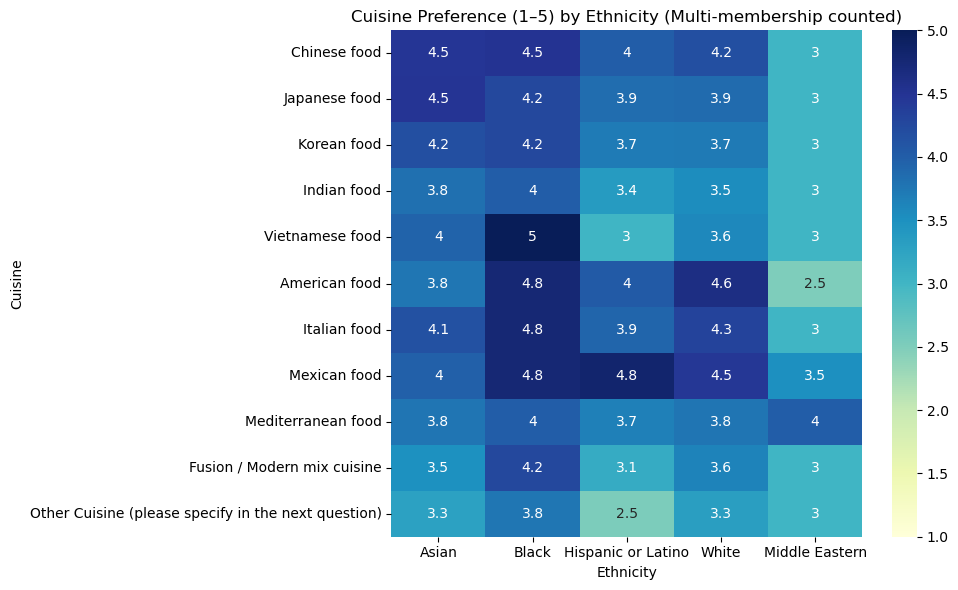

In [47]:
# Lydia's Chunk: Heatmap Visualization (Multi-Membership Counting)
# Comparing cuisine preference (Likert 1–5) by ethnicity
# Ethnicity handling (DM):
#   - Parse free-text / multi-select ethnicity responses
#   - If a respondent lists multiple target groups, include their row in EACH group (double-count allowed)
#   - Target groups (case-insensitive): Asian, Black, Hispanic or Latino, White, Middle Eastern
# Cuisine preference columns (EV–FE):
#   - Detected automatically (questions containing:
#     "Please rank the following cuisines by your preference")
#     e.g.,
#       • Please rank the following cuisines by your preference. (1 being dislike, 5 being like) [Japanese food]
#       • Please rank the following cuisines by your preference. (1 being dislike, 5 being like) [Mexican food]
#       • …

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import re

# ---- Load ----
df = pd.read_csv("responses.csv")

# ---- Normalize headers (handle newlines / smart quotes) ----
def _norm(c: str) -> str:
    c = str(c)
    c = c.replace("\r", " ").replace("\n", " ")
    c = c.replace("“", '"').replace("”", '"').replace("’", "'")
    c = re.sub(r"\s+", " ", c).strip()
    return c

df.columns = [_norm(c) for c in df.columns]

# ---- Detect columns ----
eth_cols = [c for c in df.columns if "ethnic" in c.lower()]
assert eth_cols, "Could not find an ethnicity column (searching for 'ethnic')."
eth_col = eth_cols[0]

cuisine_cols = [
    c for c in df.columns
    if "please rank the following cuisines by your preference" in c.lower()
]
assert cuisine_cols, "No cuisine preference columns found."

# ---- Clean cuisine Likert values to integers 1–5 ----
def clean_rating(x):
    if pd.isna(x):
        return np.nan
    s = str(x).strip()
    for ch in s:
        if ch.isdigit():
            return int(ch)
    return np.nan

df[cuisine_cols] = df[cuisine_cols].applymap(clean_rating)

# ---- Ethnicity pattern map (expand as needed) ----
TARGET_ETH = ["Asian", "Black", "Hispanic or Latino", "White", "Middle Eastern"]

ETH_MAP = {
    "Asian": [
        r"\basian\b", r"\beast\s*asian\b", r"\bsouth\s*asian\b", r"\bsouth\s*east\s*asian\b",
        r"\bkorean\b", r"\bjapanese\b", r"\bchinese\b", r"\bfilipin[a|o]\b",
        r"\bviet(namese)?\b", r"\bindian\b", r"\bthai\b"
    ],
    "Black": [
        r"\bblack\b", r"\bafrican\s*american\b", r"\bafrican\b"
    ],
    "Hispanic or Latino": [
        r"\bhispanic\b", r"\blatin[oa]\b", r"\blatinx\b", r"\blatine\b"
    ],
    "White": [
        r"\bwhite\b", r"\bcaucasian\b", r"\beuropean\b"
    ],
    "Middle Eastern": [
        r"\bmiddle[-\s]*eastern\b", r"\bmena\b", r"\barab(ic)?\b", r"\biranian\b", r"\bpersian\b",
        r"\bturk(ish)?\b", r"\bkurd(ish)?\b"
    ],
}

ETH_PATTERNS = {label: re.compile("|".join(pats), flags=re.I) for label, pats in ETH_MAP.items()}

def match_ethnicities(value: str):
    """Return a list of all target ethnicities that appear in the response (case-insensitive)."""
    if pd.isna(value):
        return []
    s = _norm(str(value))
    # split common multi-select delimiters to help matching; still search across entire string
    parts = re.split(r"[;,/]| and | & ", s, flags=re.I)
    found = set()
    for p in parts:
        for label, rx in ETH_PATTERNS.items():
            if rx.search(p):
                found.add(label)
    return sorted(found)

# ---- Explode respondents into multiple rows for multi-ethnicity matches ----
# Keep only respondents that match at least one target ethnicity
matches = df[eth_col].apply(match_ethnicities)
mask_has_any = matches.apply(lambda lst: len(lst) > 0)
df_multi = df.loc[mask_has_any].copy()
df_multi["__EthList"] = matches[mask_has_any]

# Explode: one row per (respondent x matched ethnicity)
df_exploded = df_multi.explode("__EthList", ignore_index=True)
df_exploded = df_exploded.rename(columns={"__EthList": "Ethnicity_Simplified"})

# ---- (Optional) ensure order of categories for plotting ----
df_exploded["Ethnicity_Simplified"] = pd.Categorical(
    df_exploded["Ethnicity_Simplified"], categories=TARGET_ETH, ordered=False
)

# ---- Compute mean cuisine ratings PER ethnicity (after explosion) ----
mean_by_eth = df_exploded.groupby("Ethnicity_Simplified", dropna=False)[cuisine_cols].mean()

# ---- Pretty cuisine labels (text inside [...]) ----
pretty_names = {c: c.split('[')[-1].split(']')[0] if '[' in c and ']' in c else c for c in mean_by_eth.columns}
mean_by_eth = mean_by_eth.rename(columns=pretty_names)

# ---- Reindex to consistent ethnicity order and drop all-NaN columns/rows safely ----
mean_by_eth = mean_by_eth.reindex(index=TARGET_ETH)
mean_by_eth = mean_by_eth.dropna(axis=1, how="all")

# ---- Heatmap ----
plt.figure(figsize=(10, 6))
sns.heatmap(mean_by_eth.T, annot=True, cmap="YlGnBu", vmin=1, vmax=5)
plt.title("Cuisine Preference (1–5) by Ethnicity (Multi-membership counted)")
plt.xlabel("Ethnicity")
plt.ylabel("Cuisine")
plt.tight_layout()
plt.show()

# --- Optional diagnostics:
# print("Counts per ethnicity after explosion:\n", df_exploded["Ethnicity_Simplified"].value_counts(dropna=False))


C:\Users\Jonat\AppData\Local\Temp\ipykernel_9004\3550132744.py:40: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df[cuisine_cols] = df[cuisine_cols].applymap(clean_rating)


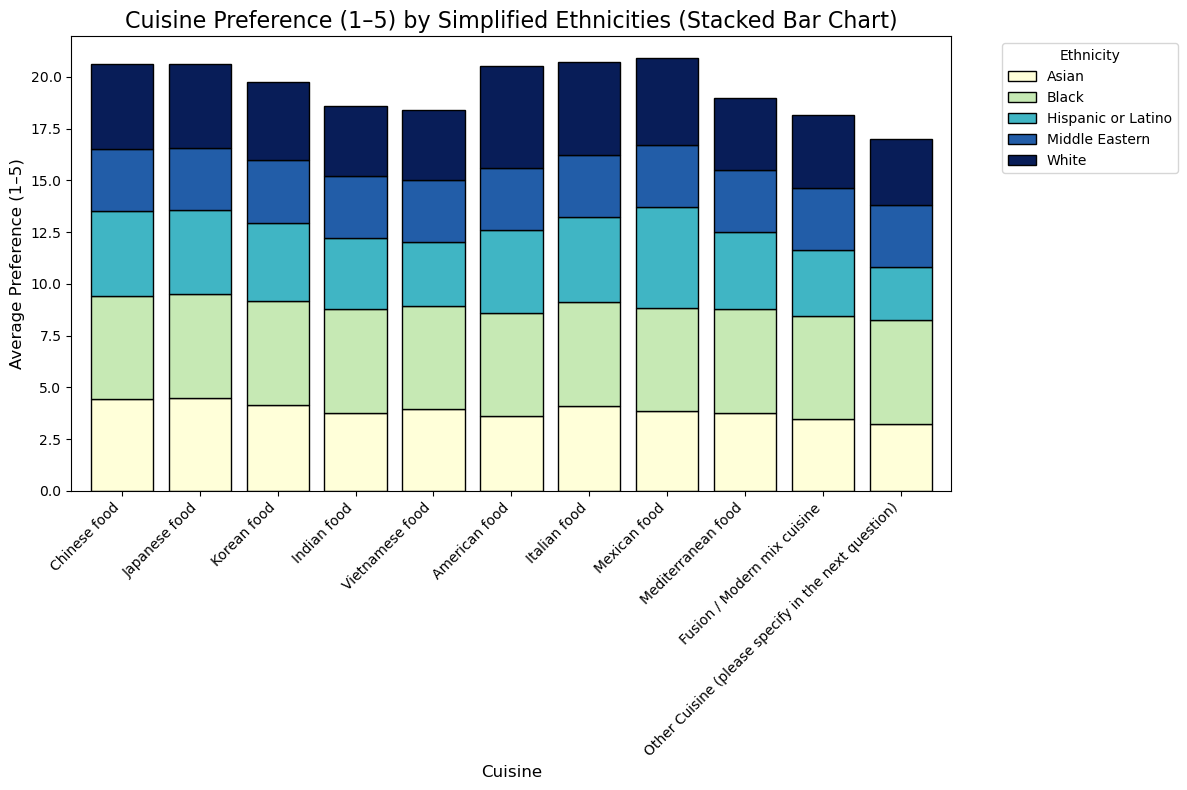

In [48]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re

# ---- Load the dataset ----
df = pd.read_csv("responses.csv")

# ---- Normalize headers (remove newlines / smart quotes) ----
def _norm(s: str) -> str:
    s = str(s)
    s = s.replace("\r", " ").replace("\n", " ")
    s = s.replace("“", '"').replace("”", '"').replace("’", "'")
    s = re.sub(r"\s+", " ", s).strip()
    return s

df.columns = [_norm(c) for c in df.columns]

# ---- Detect columns ----
eth_cols = [c for c in df.columns if "ethnic" in c.lower()]
assert eth_cols, "Could not find an ethnicity column (searching for 'ethnic')."
eth_col = eth_cols[0]

cuisine_cols = [
    c for c in df.columns
    if "Please rank the following cuisines by your preference" in c
]
assert cuisine_cols, "No cuisine preference columns found."

# ---- Clean Likert values (pull first digit 1–5) ----
def clean_rating(x):
    if pd.isna(x):
        return np.nan
    x = str(x).strip()
    for ch in x:
        if ch.isdigit():
            return int(ch)
    return np.nan

df[cuisine_cols] = df[cuisine_cols].applymap(clean_rating)

# ---- Define simplified ethnicities ----
simplified_ethnicities = ["Asian", "Black", "Hispanic or Latino", "Middle Eastern", "White"]

# ---- Filter data by ethnicity ----
df_filtered = df[df[eth_col].isin(simplified_ethnicities)]

# ---- Average by simplified ethnicity ----
mean_by_eth = df_filtered.groupby(eth_col, dropna=False)[cuisine_cols].mean()

# ---- Pretty cuisine labels ----
pretty_names = {c: c.split('[')[-1].split(']')[0] for c in mean_by_eth.columns}
mean_by_eth = mean_by_eth.rename(columns=pretty_names)

# ---- Plot: Stacked Bar Chart ----
ax = mean_by_eth.T.plot(kind="bar", stacked=True, figsize=(12, 8), cmap="YlGnBu", width=0.8, edgecolor="black")

# ---- Titles and labels ----
plt.title("Cuisine Preference (1–5) by Simplified Ethnicities (Stacked Bar Chart)", fontsize=16)
plt.xlabel("Cuisine", fontsize=12)
plt.ylabel("Average Preference (1–5)", fontsize=12)

# ---- Add legend and adjust labels ----
plt.legend(title="Ethnicity", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.xticks(rotation=45, ha="right")

# ---- Show plot ----
plt.tight_layout()
plt.show()


C:\Users\Jonat\AppData\Local\Temp\ipykernel_9004\1329493498.py:40: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df[cuisine_cols] = df[cuisine_cols].applymap(clean_rating)


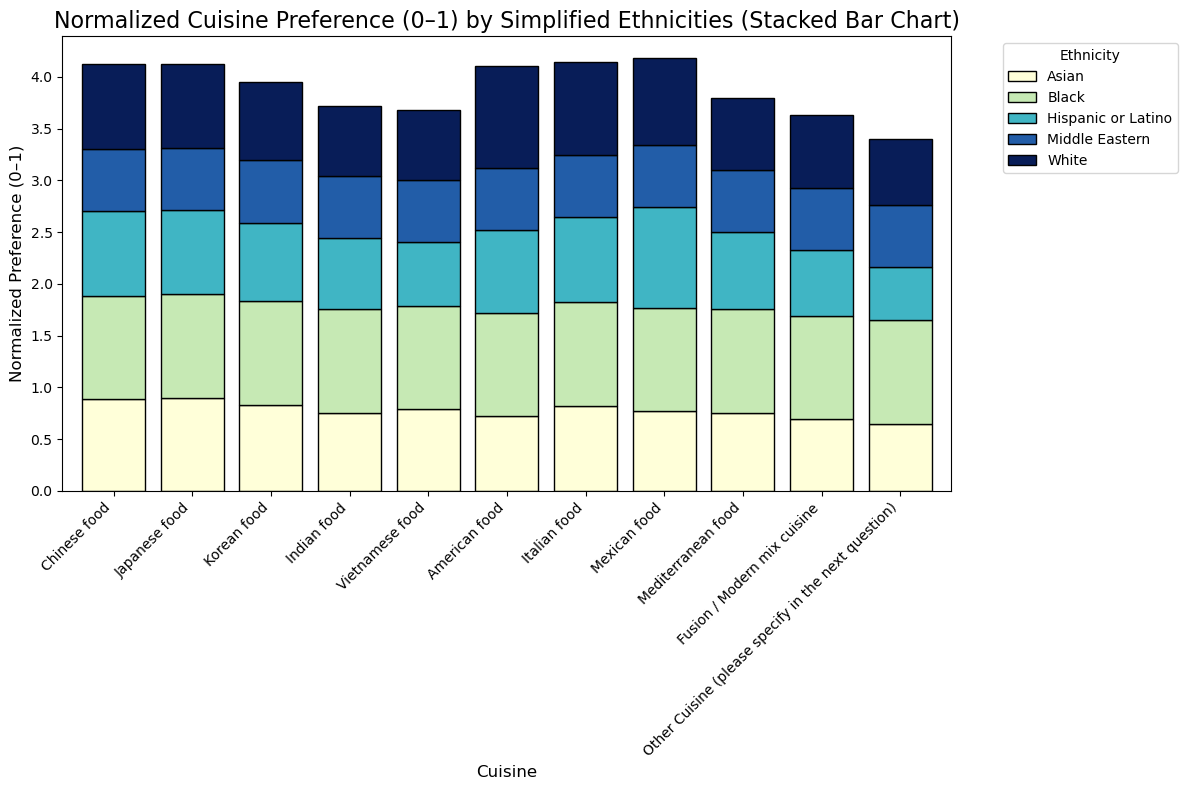

In [49]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re

# ---- Load the dataset ----
df = pd.read_csv("responses.csv")

# ---- Normalize headers (remove newlines / smart quotes) ----
def _norm(s: str) -> str:
    s = str(s)
    s = s.replace("\r", " ").replace("\n", " ")
    s = s.replace("“", '"').replace("”", '"').replace("’", "'")
    s = re.sub(r"\s+", " ", s).strip()
    return s

df.columns = [_norm(c) for c in df.columns]

# ---- Detect columns ----
eth_cols = [c for c in df.columns if "ethnic" in c.lower()]
assert eth_cols, "Could not find an ethnicity column (searching for 'ethnic')."
eth_col = eth_cols[0]

cuisine_cols = [
    c for c in df.columns
    if "Please rank the following cuisines by your preference" in c
]
assert cuisine_cols, "No cuisine preference columns found."

# ---- Clean Likert values (pull first digit 1–5) ----
def clean_rating(x):
    if pd.isna(x):
        return np.nan
    x = str(x).strip()
    for ch in x:
        if ch.isdigit():
            return int(ch)
    return np.nan

df[cuisine_cols] = df[cuisine_cols].applymap(clean_rating)

# ---- Define simplified ethnicities ----
simplified_ethnicities = ["Asian", "Black", "Hispanic or Latino", "Middle Eastern", "White"]

# ---- Filter data by ethnicity ----
df_filtered = df[df[eth_col].isin(simplified_ethnicities)]

# ---- Average by simplified ethnicity ----
mean_by_eth = df_filtered.groupby(eth_col, dropna=False)[cuisine_cols].mean()

# ---- Normalize data by dividing each ethnicity's rating by the max rating for each cuisine ----
mean_by_eth_normalized = mean_by_eth.div(mean_by_eth.max(axis=0), axis=1)

# ---- Pretty cuisine labels ----
pretty_names = {c: c.split('[')[-1].split(']')[0] for c in mean_by_eth_normalized.columns}
mean_by_eth_normalized = mean_by_eth_normalized.rename(columns=pretty_names)

# ---- Plot: Stacked Bar Chart (Normalized) ----
ax = mean_by_eth_normalized.T.plot(kind="bar", stacked=True, figsize=(12, 8), cmap="YlGnBu", width=0.8, edgecolor="black")

# ---- Titles and labels ----
plt.title("Normalized Cuisine Preference (0–1) by Simplified Ethnicities (Stacked Bar Chart)", fontsize=16)
plt.xlabel("Cuisine", fontsize=12)
plt.ylabel("Normalized Preference (0–1)", fontsize=12)

# ---- Add legend and adjust labels ----
plt.legend(title="Ethnicity", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.xticks(rotation=45, ha="right")

# ---- Show plot ----
plt.tight_layout()
plt.show()
